<a href="https://colab.research.google.com/github/SJinLee/PPG/blob/main/03.LF_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!unzip -d input drive/MyDrive/ppg/archive.zip

Archive:  drive/MyDrive/ppg/archive.zip
  inflating: input/gamer1-annotations.csv  
  inflating: input/gamer1-ppg-2000-01-01.csv  
  inflating: input/gamer1-ppg-2000-01-02.csv  
  inflating: input/gamer2-annotations.csv  
  inflating: input/gamer2-ppg-2000-01-01.csv  
  inflating: input/gamer2-ppg-2000-01-02.csv  
  inflating: input/gamer3-annotations.csv  
  inflating: input/gamer3-ppg-2000-01-01.csv  
  inflating: input/gamer3-ppg-2000-01-02.csv  
  inflating: input/gamer4-annotations.csv  
  inflating: input/gamer4-ppg-2000-01-01.csv  
  inflating: input/gamer4-ppg-2000-01-02.csv  
  inflating: input/gamer5-annotations.csv  
  inflating: input/gamer5-ppg-2000-01-01.csv  
  inflating: input/gamer5-ppg-2000-01-02.csv  


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
gamerID = 'gamer5'

In [6]:
dateCols = ['Datetime']
anots = pd.read_csv('./input/' + gamerID + '-annotations.csv', parse_dates=dateCols)
anots.dataframeName = gamerID + '-annotations'
anots.shape

(86, 3)

In [7]:
sss = anots[anots.Event == "Stanford Sleepiness Self-Assessment (1-7)"].drop('Event', axis=1).copy()
sss['SelfAssess'] = sss['Value'].map(lambda x: float(x))

rt = anots[anots.Event == "Sleep-2-Peak Reaction Time (ms)"].drop('Event', axis=1).copy()
rt['ReactTime'] = rt['Value'].map(lambda x: float(x))

diary = anots[anots.Event == "Diary Entry (text)"].drop('Event', axis=1).copy()

In [46]:
nRowsRead = None
ppg = pd.read_csv('./input/' + gamerID + '-ppg-2000-01-01.csv', delimiter=',', nrows = nRowsRead)
ppg.dataframeName = gamerID + '-ppg-2000-01-01.csv'
ppg['Time'] = ppg['Time'].str.replace('(^)','2000-01-01 ')
ppg_next = pd.read_csv('./input/' + gamerID + '-ppg-2000-01-02.csv', delimiter=',', nrows = nRowsRead)
ppg_next.dataframeName = gamerID + '-ppg-2000-01-02.csv'
ppg_next['Time'] = ppg_next['Time'].str.replace('(^)','2000-01-02 ')
ppg = pd.concat([ppg,ppg_next],axis=0).reset_index(drop=True)
ppg.shape

<ipython-input-46-07c68919c00b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  ppg['Time'] = ppg['Time'].str.replace('(^)','2000-01-01 ')
<ipython-input-46-07c68919c00b>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  ppg_next['Time'] = ppg_next['Time'].str.replace('(^)','2000-01-02 ')


(7043488, 2)

In [114]:
ppg2 = ppg.copy()
while True:
    idx = ppg2['Red_Signal'].iloc[:-1].values == ppg2['Red_Signal'].iloc[1:].values
    if idx.any() == False:
        break
    idx = np.concatenate([[False],idx])
    ppg2 = ppg2[~idx]

In [123]:
idx = ppg2['Red_Signal'].iloc[:-2].values < ppg2['Red_Signal'].iloc[1:-1].values
idx &= ppg2['Red_Signal'].iloc[2:].values < ppg2['Red_Signal'].iloc[1:-1].values
idx &= ppg2['Red_Signal'].iloc[1:-1].values > 650
idx = np.where(idx)[0]

In [124]:
a = pd.to_datetime(ppg2.iloc[idx+1]['Time']).diff().iloc[1:] / pd.to_timedelta(1, unit='S')

In [125]:
a.min(),a.max()

(0.0, 3508.499427)

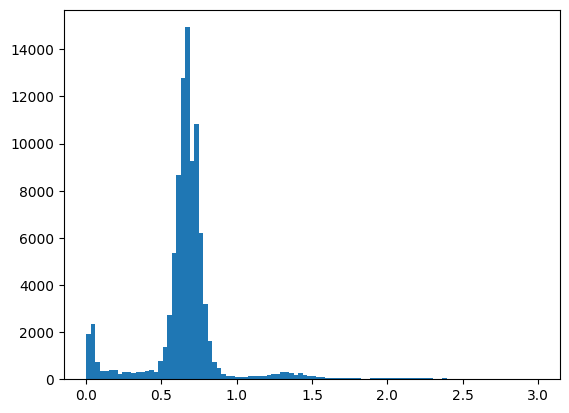

In [126]:
plt.hist(a.loc[a<3],bins=100)
plt.show()

In [127]:
a.loc[(a>1.3)&(a<1.4)]

22398      1.344063
25003      1.306750
44521      1.392181
50075      1.344698
72419      1.391526
             ...   
6826215    1.312466
6837823    1.359881
6873769    1.360359
6911720    1.344656
6963695    1.360048
Name: Time, Length: 922, dtype: float64

In [128]:
a.loc[22398:22398+3000]

22398    1.344063
22460    0.623081
22520    0.608534
22577    0.560618
22638    0.623809
22698    0.591658
22768    0.704842
22836    0.687081
22911    0.752348
22979    0.671690
23045    0.656741
23114    0.703242
23192    0.784187
23261    0.688179
23337    0.752488
23402    0.655456
23466    0.639694
23532    0.672320
23602    0.688148
23677    0.752456
23753    0.767063
23827    0.736715
23900    0.735100
23923    0.224484
23975    0.527498
24047    0.720342
24117    0.704042
24187    0.703963
24255    0.672328
24324    0.703242
24392    0.672236
24463    0.720037
24536    0.720305
24608    0.719697
24678    0.704554
24739    0.623543
24810    0.704158
24846    0.367300
24871    0.261585
25003    1.306750
25066    0.624790
25136    0.703627
25201    0.655912
25270    0.688252
25332    0.623644
25394    0.623475
Name: Time, dtype: float64

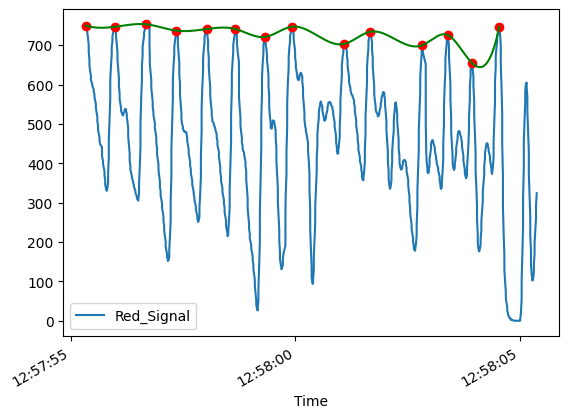

In [171]:
from scipy import interpolate
ppgseg = ppg.loc[20044:20044+1000].copy()
ppgseg['Time'] = pd.to_datetime(ppgseg['Time'])
ppgseg.set_index('Time').plot()
ppgpeak = ppgseg.loc[a.loc[20044:20044+1000].index]
plt.plot(ppgpeak['Time'],ppgpeak['Red_Signal'],'ro')
ff = (ppgpeak['Time']-ppgpeak['Time'].iloc[0]) / pd.to_timedelta(1, unit='S')
f_cubic = interpolate.interp1d(ff,
                               ppgpeak['Red_Signal'], kind='cubic') # , quadratic
xnew = np.arange(ppgpeak['Time'].iloc[0]-ppgpeak['Time'].iloc[0],
                 ppgpeak['Time'].iloc[-1]-ppgpeak['Time'].iloc[0],100)
xnew = xnew / pd.to_timedelta(1, unit='S')
y_new = f_cubic(xnew)
xnew2 = np.arange(ppgpeak['Time'].iloc[0],
                 ppgpeak['Time'].iloc[-1],100)
plt.plot(pd.to_datetime(xnew2),y_new,color='green')